In [2]:
import pickle
from pathlib import Path
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib as mpl
from lameg.util import get_files, make_directory, check_many
from scipy.spatial.distance import euclidean
from scipy.stats import spearmanr
from scipy.spatial import KDTree
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [3]:
def norm_res(mx):
    norm = np.zeros(mx.shape)
    for l in range(mx.shape[0]):
        normed = mx[l,:] - np.min(mx[l,:])
        norm[l,:] = normed
    return norm


def find_peaks(mx, marker="*", return_annot=True):
    annot = np.zeros(mx.shape).astype(np.object_)
    peaks = []
    for l in range(mx.shape[0]):
        peak = np.argmax(mx[l, :]) # here is the problem (you find peak in evaluated!)
        annot[l, peak] = 1.0
        peaks.append(peak)
    peaks = np.array(peaks)
    annot_bin = np.copy(annot).astype(float)
    annot[annot==0.0] = None
    annot[annot==1.0] = marker
    if return_annot:
        return peaks, annot, annot_bin
    else:
        return peaks


def bootstrap(data, n_boot=1000, prop=0.5):
    n_rows = data.shape[0]
    rows = np.arange(n_rows)
    prop_rows = int(n_rows*prop)
    results = []
    for b in range(n_boot):
        boot_rows = np.random.choice(rows, size=prop_rows)
        results.append(data[boot_rows])
    return np.array(results)


def shuffled_peak_error(mx, ab=False):
    mx_sh = shuffle_mx(mx)
    peaks = find_peaks(mx_sh, return_annot=False)
    peaks = peaks - np.arange(mx.shape[0])
    if not ab:
        return peaks
    else:
        return np.abs(peaks)


def shuffle_mx(mx):
    mx_shape = mx.shape
    mx = mx.flatten()
    np.random.shuffle(mx)
    return mx.reshape(mx_shape)

In [4]:
n_layers = 11
layers = np.arange(n_layers)
vx_loc, vx_adj, surf_norm = nib.load(Path("/scratch/coreg_analysis/multilayer.11.ds.link_vector.fixed.gii")).agg_data()
layers_loc = np.array(np.split(vx_loc, n_layers, axis=0))
cortical_thickness = np.array([euclidean(layers_loc[0, i, :], layers_loc[-1, i, :]) for i in range(layers_loc.shape[1])])

In [5]:
out = Path("/scratch/coreg_analysis/img_outputs")

In [9]:
coreg_res = Path("/scratch/coreg_analysis/coreg_err_simulations/")
coreg_files = get_files(coreg_res, "*.pickle")
fnms = np.array([[i] + i.stem.split("_") for i in coreg_files])
map_fnms = np.array([i in [1, 3, 5, 6] for i in range(7)])
fnms = fnms[:,~map_fnms]
names_ = ["filename", "vx", "coreg_error"]
coreg_files = pd.DataFrame.from_dict(
    {k: fnms[:,i] for i, k in enumerate(names_)}
)
coreg_files["matrix"] = None
coreg_files["norm_matrix"] = None
coreg_files["peaks"] = None
coreg_files["cortical_thickness"] = None
coreg_files["error"] = None
coreg_files["bias"] = None
coreg_files["sum_error"] = None
coreg_files["sum_error_mm"] = None
coreg_files["error_mm"] = None
coreg_files["bias_mm"] = None
coreg_files.vx = coreg_files.vx.apply(lambda x: eval(x))
coreg_files.coreg_error = coreg_files.coreg_error.apply(lambda x: eval(x))
mxs = []
for ix, row in coreg_files.iterrows():
    with open(row.filename, "rb") as file:
        output = pickle.load(file)
    output = output["layerF"]
    coreg_files.at[ix, "matrix"] = output
    mx = norm_res(output)
    coreg_files.at[ix, "norm_matrix"] = mx
    peaks, annot, annot_bin = find_peaks(mx, marker=r"$\wedge$")
    layer_multiplier = cortical_thickness[row.vx] / n_layers
    coreg_files.at[ix, "peaks"] = peaks
    coreg_files.at[ix, "cortical_thickness"] = cortical_thickness[row.vx]
    coreg_files.at[ix, "error"] = np.abs(layers - peaks)
    coreg_files.at[ix, "bias"] = layers - peaks
    coreg_files.at[ix, "error_mm"] = np.mean(np.abs(layers * layer_multiplier - peaks * layer_multiplier))
    coreg_files.at[ix, "bias_mm"] = np.mean(layers * layer_multiplier - peaks * layer_multiplier)
    coreg_files.at[ix, "sum_error"] = np.sum(np.abs(layers - peaks))
    coreg_files.at[ix, "sum_error_mm"] = np.sum(np.abs(layers * layer_multiplier - peaks * layer_multiplier))

In [10]:
coreg_range = coreg_files.coreg_error.unique()
coreg_range.sort()
coreg_files.columns

Index(['filename', 'vx', 'coreg_error', 'matrix', 'norm_matrix', 'peaks',
       'cortical_thickness', 'error', 'bias', 'sum_error', 'sum_error_mm',
       'error_mm', 'bias_mm'],
      dtype='object')

In [11]:
error_lines = []
bias_lines = []
error_res = []
bias_res = []
shuf_error_res = []
shuf_bias_res = []

for coreg_error in coreg_range:
    matrices = coreg_files.loc[coreg_files.coreg_error == coreg_error].norm_matrix.values.tolist()
    bias = np.array(coreg_files.loc[coreg_files.coreg_error == coreg_error].bias.to_list())
    bias = np.mean(bias, axis=-1)
    error = np.array(coreg_files.loc[coreg_files.coreg_error == coreg_error].error.to_list())
    error = np.mean(error, axis=-1)

    bias_bs = np.mean(bootstrap(bias, n_boot=5000), axis=1)
    error_bs = np.mean(bootstrap(error, n_boot=5000), axis=1)

    shuf_error = np.array([shuffled_peak_error(i, ab=True) for i in matrices*10])
    shuf_error = np.mean(shuf_error, axis=-1)
    shuf_error_bs = np.mean(bootstrap(shuf_error, n_boot=5000), axis=1)

    shuf_bias = np.array([shuffled_peak_error(i, ab=False) for i in matrices*10])
    shuf_bias = np.mean(shuf_bias, axis=-1)
    shuf_bias_bs = np.mean(bootstrap(shuf_bias, n_boot=5000), axis=1)

    # mean 95% CI
    error_95ci = [
        np.percentile(error_bs, 2.5), 
        np.percentile(error_bs, 97.5)
    ]

    error_95ci_shuf = [
        np.percentile(shuf_error_bs, 2.5), 
        np.percentile(shuf_error_bs, 97.5)
    ]

    bias_95ci = [
        np.percentile(bias_bs, 2.5), 
        np.percentile(bias_bs, 97.5)
    ]

    bias_95ci_shuf = [
        np.percentile(shuf_bias_bs, 2.5), 
        np.percentile(shuf_bias_bs, 97.5)
    ]

    # 75%  of data

    error_75p = [
        np.percentile(error, 12.5), 
        np.percentile(error, 87.5)
    ]

    error_75p_shuf = [
        np.percentile(shuf_error, 12.5), 
        np.percentile(shuf_error, 87.5)
    ]

    bias_75p = [
        np.percentile(bias, 12.5), 
        np.percentile(bias, 87.5)
    ]

    bias_75p_shuf = [
        np.percentile(shuf_bias, 12.5), 
        np.percentile(shuf_bias, 87.5)
    ]
    error_lines.append(error)
    bias_lines.append(bias)
    error_res.append([np.mean(error)] + error_95ci + error_75p)
    bias_res.append([np.mean(bias)] + bias_95ci + bias_75p)
    shuf_error_res.append([np.mean(shuf_error)] + error_95ci_shuf + error_75p_shuf)
    shuf_bias_res.append([np.mean(shuf_bias)] + bias_95ci_shuf + bias_75p_shuf)

error_lines = np.array(error_lines)
bias_lines = np.array(bias_lines)
error_res = np.array(error_res)
bias_res = np.array(bias_res)
shuf_error_res = np.array(shuf_error_res)
shuf_bias_res = np.array(shuf_bias_res)

In [17]:
tick_labels = [f"{i}" for i in coreg_range]
coreg_error_ix = np.arange(coreg_range.shape[0])

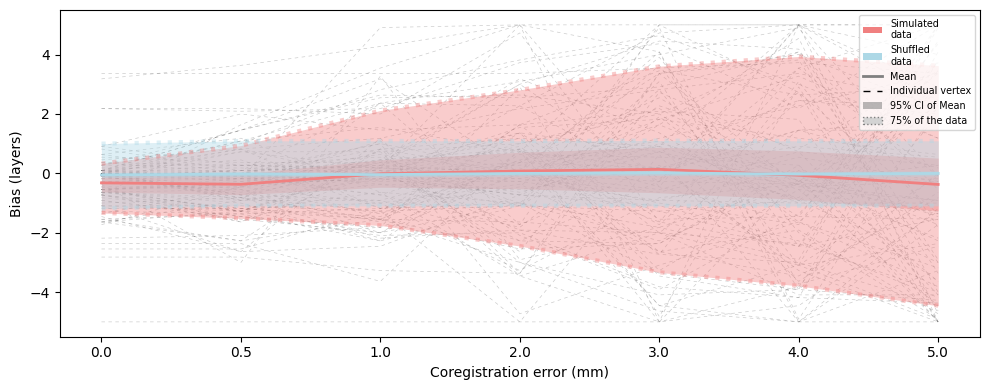

In [19]:
output_sum = Path("/scratch/coreg_analysis/img_outputs/")

legend_handles = [
    Patch(facecolor="lightcoral", linewidth=0, label="Simulated\ndata"),
    Patch(facecolor="lightblue", linewidth=0, label="Shuffled\ndata"),
    Line2D([0], [0], color="gray", lw=2, label="Mean"),
    Line2D([0], [0], color="black", lw=1, linestyle='--', dashes=(5, 5), label="Individual vertex"),
    Patch(facecolor="gray", linewidth=0, label="95% CI of Mean", alpha=0.55),
    Patch(facecolor="lightgray", label="75% of the data", linestyle=":", edgecolor="gray"),
]

f, ax = plt.subplots(1, 1, figsize=(10,4), facecolor="white")

clrs = ["lightcoral", "lightblue"]
labs = ["simulated data", "shuffled data"]

for rix, r in enumerate([bias_res, shuf_bias_res]):
    ax.plot(coreg_error_ix, r[:,0], color=clrs[rix], lw=2)
    ax.fill_between(coreg_error_ix, r[:,1], r[:,2], color=clrs[rix], lw=0, alpha=0.4)
    ax.fill_between(coreg_error_ix, r[:,3], r[:,4], color=clrs[rix], lw=0.1, alpha=0.4)
    
    ax.plot(coreg_error_ix, r[:,3], ":", lw=3, color=clrs[rix], alpha=0.4)
    ax.plot(coreg_error_ix, r[:,4], ":", lw=3, color=clrs[rix], alpha=0.4)

ax.set_xticks(coreg_error_ix)
ax.set_xticklabels(tick_labels)
ax.set_ylabel("Bias (layers)")
ax.set_xlabel("Coregistration error (mm)")
ax.legend(handles=legend_handles, fontsize="x-small", loc=1)

ax.plot(coreg_error_ix, bias_lines, lw=0.5, c="black", alpha=0.2, linestyle='--', dashes=(5, 5), zorder=0);
plt.tight_layout()

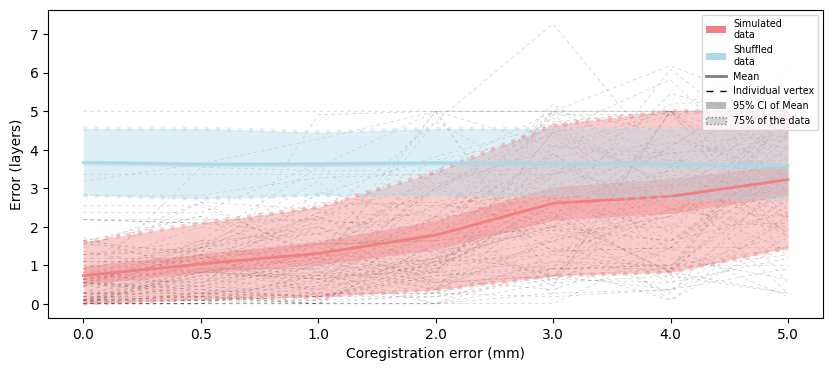

In [21]:
output_sum = Path("/scratch/coreg_analysis/img_outputs/")

legend_handles = [
    Patch(facecolor="lightcoral", linewidth=0, label="Simulated\ndata"),
    Patch(facecolor="lightblue", linewidth=0, label="Shuffled\ndata"),
    Line2D([0], [0], color="gray", lw=2, label="Mean"),
    Line2D([0], [0], color="black", lw=1, linestyle='--', dashes=(5, 5), label="Individual vertex"),
    Patch(facecolor="gray", linewidth=0, label="95% CI of Mean", alpha=0.55),
    Patch(facecolor="lightgray", label="75% of the data", linestyle=":", edgecolor="gray"),
]

f, ax = plt.subplots(1, 1, figsize=(10,4), facecolor="white")

clrs = ["lightcoral", "lightblue"]
labs = ["simulated data", "shuffled data"]

for rix, r in enumerate([error_res, shuf_error_res]):
    ax.plot(coreg_error_ix, r[:,0], color=clrs[rix], lw=2)
    ax.fill_between(coreg_error_ix, r[:,1], r[:,2], color=clrs[rix], lw=0, alpha=0.4)
    ax.fill_between(coreg_error_ix, r[:,3], r[:,4], color=clrs[rix], lw=0.1, alpha=0.4)
    
    ax.plot(coreg_error_ix, r[:,3], ":", lw=3, color=clrs[rix], alpha=0.4)
    ax.plot(coreg_error_ix, r[:,4], ":", lw=3, color=clrs[rix], alpha=0.4)

ax.set_xticks(coreg_error_ix)
ax.set_xticklabels(tick_labels)
ax.set_ylabel("Error (layers)")
ax.set_xlabel("Coregistration error (mm)")
ax.legend(handles=legend_handles, fontsize="x-small", loc=1)

ax.plot(coreg_error_ix, error_lines, lw=0.5, c="black", alpha=0.2, linestyle='--', dashes=(5, 5), zorder=0);

In [23]:
# mm

error_lines_mm = []
bias_lines_mm = []
error_res_mm = []
bias_res_mm = []
shuf_error_res_mm = []
shuf_bias_res_mm = []

for coreg_error in coreg_range:
    layer_mpl = snr_files.loc[snr_files.coreg_error == coreg_error].cortical_thickness.to_numpy() / 11
    matrices = coreg_files.loc[coreg_files.coreg_error == coreg_error].norm_matrix.values.tolist()
    bias = np.array(coreg_files.loc[coreg_files.coreg_error == coreg_error].bias.to_list())
    bias = np.mean(bias, axis=-1) * layer_mpl
    error = np.array(coreg_files.loc[coreg_files.coreg_error == coreg_error].error.to_list())
    error = np.mean(error, axis=-1) * layer_mpl

    bias_bs = np.mean(bootstrap(bias, n_boot=5000), axis=1)
    error_bs = np.mean(bootstrap(error, n_boot=5000), axis=1)

    shuf_error = np.array([shuffled_peak_error(i, ab=True) for i in matrices*10])
    shuf_error = np.mean(shuf_error, axis=-1) * np.tile(layer_mpl, 10)
    shuf_error_bs = np.mean(bootstrap(shuf_error, n_boot=5000), axis=1)

    shuf_bias = np.array([shuffled_peak_error(i, ab=False) for i in matrices*10])
    shuf_bias = np.mean(shuf_bias, axis=-1)
    shuf_bias_bs = np.mean(bootstrap(shuf_bias, n_boot=5000), axis=1)

    # mean 95% CI
    error_95ci = [
        np.percentile(error_bs, 2.5), 
        np.percentile(error_bs, 97.5)
    ]

    error_95ci_shuf = [
        np.percentile(shuf_error_bs, 2.5), 
        np.percentile(shuf_error_bs, 97.5)
    ]

    bias_95ci = [
        np.percentile(bias_bs, 2.5), 
        np.percentile(bias_bs, 97.5)
    ]

    bias_95ci_shuf = [
        np.percentile(shuf_bias_bs, 2.5), 
        np.percentile(shuf_bias_bs, 97.5)
    ]

    # 75%  of data

    error_75p = [
        np.percentile(error, 12.5), 
        np.percentile(error, 87.5)
    ]

    error_75p_shuf = [
        np.percentile(shuf_error, 12.5), 
        np.percentile(shuf_error, 87.5)
    ]

    bias_75p = [
        np.percentile(bias, 12.5), 
        np.percentile(bias, 87.5)
    ]

    bias_75p_shuf = [
        np.percentile(shuf_bias, 12.5), 
        np.percentile(shuf_bias, 87.5)
    ]
    error_lines_mm.append(error)
    bias_lines_mm.append(bias)
    error_res_mm.append([np.mean(error)] + error_95ci + error_75p)
    bias_res_mm.append([np.mean(bias)] + bias_95ci + bias_75p)
    shuf_error_res_mm.append([np.mean(shuf_error)] + error_95ci_shuf + error_75p_shuf)
    shuf_bias_res_mm.append([np.mean(shuf_bias)] + bias_95ci_shuf + bias_75p_shuf)

error_lines_mm = np.array(error_lines_mm)
bias_lines_mm = np.array(bias_lines_mm)
error_res_mm = np.array(error_res_mm)
bias_res_mm = np.array(bias_res_mm)
shuf_error_res_mm = np.array(shuf_error_res_mm)
shuf_bias_res_mm = np.array(shuf_bias_res_mm)

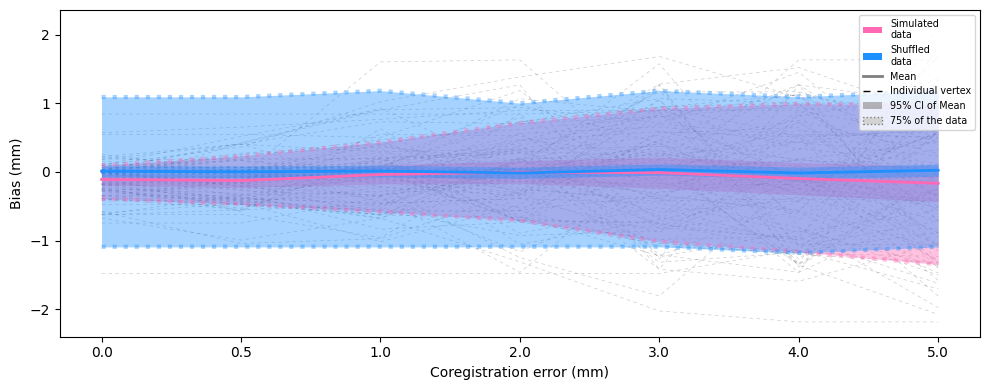

In [26]:
output_sum = Path("/scratch/coreg_analysis/img_outputs/")

legend_handles = [
    Patch(facecolor="hotpink", linewidth=0, label="Simulated\ndata"),
    Patch(facecolor="dodgerblue", linewidth=0, label="Shuffled\ndata"),
    Line2D([0], [0], color="gray", lw=2, label="Mean"),
    Line2D([0], [0], color="black", lw=1, linestyle='--', dashes=(5, 5), label="Individual vertex"),
    Patch(facecolor="gray", linewidth=0, label="95% CI of Mean", alpha=0.55),
    Patch(facecolor="lightgray", label="75% of the data", linestyle=":", edgecolor="gray"),
]

f, ax = plt.subplots(1, 1, figsize=(10,4), facecolor="white")

clrs = ["hotpink", "dodgerblue"]
labs = ["simulated data", "shuffled data"]

for rix, r in enumerate([bias_res_mm, shuf_bias_res_mm]):
    ax.plot(coreg_error_ix, r[:,0], color=clrs[rix], lw=2)
    ax.fill_between(coreg_error_ix, r[:,1], r[:,2], color=clrs[rix], lw=0, alpha=0.4)
    ax.fill_between(coreg_error_ix, r[:,3], r[:,4], color=clrs[rix], lw=0.1, alpha=0.4)
    
    ax.plot(coreg_error_ix, r[:,3], ":", lw=3, color=clrs[rix], alpha=0.4)
    ax.plot(coreg_error_ix, r[:,4], ":", lw=3, color=clrs[rix], alpha=0.4)

ax.set_xticks(coreg_error_ix)
ax.set_xticklabels(tick_labels)
ax.set_ylabel("Bias (mm)")
ax.set_xlabel("Coregistration error (mm)")
ax.legend(handles=legend_handles, fontsize="x-small", loc=1)

ax.plot(coreg_error_ix, bias_lines_mm, lw=0.5, c="black", alpha=0.2, linestyle='--', dashes=(5, 5), zorder=0);
plt.tight_layout()
plt.savefig(output_sum.joinpath(f"coreg_absolute_mm.svg"))

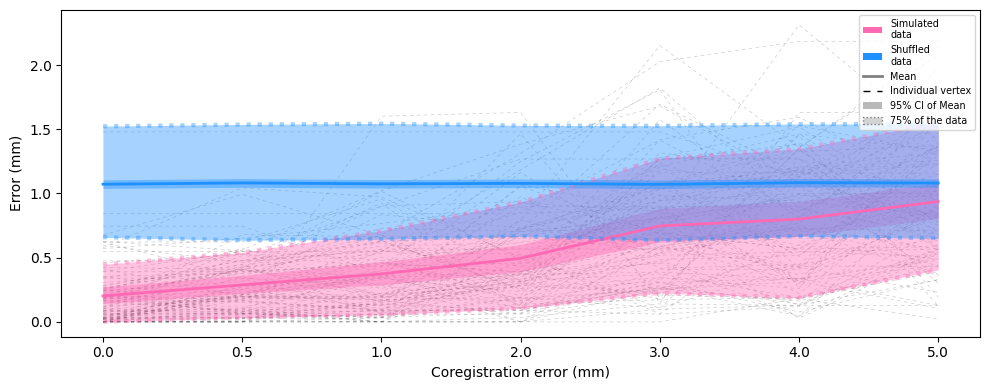

In [28]:
output_sum = Path("/scratch/coreg_analysis/img_outputs/")

legend_handles = [
    Patch(facecolor="hotpink", linewidth=0, label="Simulated\ndata"),
    Patch(facecolor="dodgerblue", linewidth=0, label="Shuffled\ndata"),
    Line2D([0], [0], color="gray", lw=2, label="Mean"),
    Line2D([0], [0], color="black", lw=1, linestyle='--', dashes=(5, 5), label="Individual vertex"),
    Patch(facecolor="gray", linewidth=0, label="95% CI of Mean", alpha=0.55),
    Patch(facecolor="lightgray", label="75% of the data", linestyle=":", edgecolor="gray"),
]

f, ax = plt.subplots(1, 1, figsize=(10,4), facecolor="white")

clrs = ["hotpink", "dodgerblue"]
labs = ["simulated data", "shuffled data"]

for rix, r in enumerate([error_res_mm, shuf_error_res_mm]):
    ax.plot(coreg_error_ix, r[:,0], color=clrs[rix], lw=2)
    ax.fill_between(coreg_error_ix, r[:,1], r[:,2], color=clrs[rix], lw=0, alpha=0.4)
    ax.fill_between(coreg_error_ix, r[:,3], r[:,4], color=clrs[rix], lw=0.1, alpha=0.4)
    
    ax.plot(coreg_error_ix, r[:,3], ":", lw=3, color=clrs[rix], alpha=0.4)
    ax.plot(coreg_error_ix, r[:,4], ":", lw=3, color=clrs[rix], alpha=0.4)

ax.set_xticks(coreg_error_ix)
ax.set_xticklabels(tick_labels)
ax.set_ylabel("Error (mm)")
ax.set_xlabel("Coregistration error (mm)")
ax.legend(handles=legend_handles, fontsize="x-small", loc=1)

ax.plot(coreg_error_ix, error_lines_mm, lw=0.5, c="black", alpha=0.2, linestyle='--', dashes=(5, 5), zorder=0);
plt.tight_layout()
plt.savefig(output_sum.joinpath(f"coreg_bias_mm.svg"))